In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import math
import matplotlib.pyplot as plt
import os
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import matplotlib.gridspec as gridspec

## Introduction

The New York City Department of Health and Mental Hygiene (DOHMH) makes publicly avaiable the results of their restaurant inspections. As consumers this information can help us make the best choices for our safety. Grades posted on individual business help us make one off choices. However its important to note the grading scale. 

    +A: 0-13 
    +B: 14-27 
    +C: 28

There is a lot of granular data within the A and B ranges that we don't see when we look at the posted letter grade. In addition while there are shutdown and cutoff measures for operators who score very badely the C grade is an extrememly wide net. While the ideal score is 0 there is no maximum possible score.

Our stakeholders are the public consumer. Many many have already searched this database to look up the inspection details for restaurants in their neigborhood or the records of a restaurant they have never tried before in advance of a visit. There may be larger trends in the data that can offer insights about how to make the safest choices when visiting restaurants.

## Hypotheses

H<sub>0</sub>: There is no significant difference between the populations  

H<sub>A</sub>: There is a significant difference between one or more of the populations and the entire population

## Data

The data for this analysis is publicly available via the DOHMH website and can be accessed at:
https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j
This data is updated regularly. 

Some information about how inspections are scorred can be found at:
https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf


This data set contains over 400,000 entries, each a unique inspection result. It also contains 84 unique identifiers for 'CUISINE DESCRIPTION' which is too many to cover in the course of this analysis. Additionally some of these variables have very few entries. In thise case we will limit our analysis to the 5 variables with the most entries. We will also want to limit which data we use in other ways.

The DOHMH conducts many different kinds of inspections and not all result in a score. Some are rechecks if a operator had issues to be corrected on the first inspection. In order to keep our sample as representative of normal operation as possible we will consider only the scores recieved during the first visit of a random audit process.

Our populations with the top five number of entries are: American, Chinese, Cafe/coffee/tea, Latin and, Italian. Between these groups, after cleaning we have 106,971 rows.

In [3]:
df = pd.read_csv('DOHMH_Inspection_Results.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400305 entries, 0 to 400304
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  400305 non-null  int64  
 1   DBA                    399954 non-null  object 
 2   BORO                   400305 non-null  object 
 3   BUILDING               399086 non-null  object 
 4   STREET                 400229 non-null  object 
 5   ZIPCODE                393580 non-null  float64
 6   PHONE                  400287 non-null  object 
 7   CUISINE DESCRIPTION    400305 non-null  object 
 8   INSPECTION DATE        400305 non-null  object 
 9   ACTION                 398548 non-null  object 
 10  VIOLATION CODE         394293 non-null  object 
 11  VIOLATION DESCRIPTION  390916 non-null  object 
 12  CRITICAL FLAG          390916 non-null  object 
 13  SCORE                  383164 non-null  float64
 14  GRADE                  202739 non-nu

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50055236,NAKED CRAB,Queens,3916,COLLEGE POINT BLVD,11354.0,7188868777,Seafood,10/23/2018,Violations were cited in the following area(s).,...,07/18/2020,Cycle Inspection / Initial Inspection,40.758797,-73.834479,407.0,20.0,87100.0,4539543.0,4.049620e+09,QN22
1,41472986,FUJI JAPANESE RESTAURANT,Manhattan,238,WEST 56 STREET,10019.0,2125869888,Japanese,11/04/2019,Violations were cited in the following area(s).,...,07/18/2020,Cycle Inspection / Re-inspection,40.765629,-73.982423,105.0,3.0,13700.0,1024884.0,1.010270e+09,MN17
2,50015984,SHUKO,Manhattan,47,EAST 12 STREET,10003.0,6465103673,Japanese,10/30/2018,Violations were cited in the following area(s).,...,07/18/2020,Cycle Inspection / Initial Inspection,40.733456,-73.991683,102.0,2.0,6100.0,1084682.0,1.005640e+09,MN23
3,40994739,LE PAIN QUOTIDIEN,Manhattan,922,7 AVENUE,10019.0,2127570775,Sandwiches,04/23/2018,Violations were cited in the following area(s).,...,07/18/2020,Cycle Inspection / Re-inspection,40.766405,-73.979408,105.0,4.0,13700.0,1024918.0,1.010300e+09,MN17
4,50072568,GOOD TASTE,Bronx,2428,CRESTON AVENUE,10468.0,7189338888,Asian,11/29/2018,Violations were cited in the following area(s).,...,07/18/2020,Cycle Inspection / Re-inspection,40.861446,-73.898831,205.0,14.0,23703.0,2013795.0,2.031650e+09,BX40


## Methods


Unfortounately our data dictionary doesn't tell us anything about these types of inpsections. Many of these types however such as re-inspections mean that the operators could have advance notice of an inspection and may change their behavior accordingly We will use only the 'Cycle Inspection / Initial Inspection' values  as these are the inspections most likley to be conducted at random.

The data will be further cleaned for null values and grouped into populations corresponding with their 'CUISINE DESCRIPTION' variable. 

Then we will examine distribution for normality and select an appropriate significanace test.

 

In [4]:
# There are a lot of columns we don't need.
base = df[['CAMIS', 'CUISINE DESCRIPTION', 'SCORE', 'CRITICAL FLAG', 'INSPECTION TYPE'
           , 'INSPECTION DATE', 'DBA']]

In [345]:
base.info()
base.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400305 entries, 0 to 400304
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CAMIS                400305 non-null  int64  
 1   CUISINE DESCRIPTION  400305 non-null  object 
 2   SCORE                383164 non-null  float64
 3   CRITICAL FLAG        390916 non-null  object 
 4   INSPECTION TYPE      398548 non-null  object 
 5   INSPECTION DATE      400305 non-null  object 
 6   DBA                  399954 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 21.4+ MB


,CAMIS,CUISINE DESCRIPTION,SCORE,CRITICAL FLAG,INSPECTION TYPE,INSPECTION DATE,DBA
0,50055236,Seafood,22.0,Y,Cycle Inspection / Initial Inspection,10/23/2018,NAKED CRAB
1,41472986,Japanese,11.0,N,Cycle Inspection / Re-inspection,11/04/2019,FUJI JAPANESE RESTAURANT
2,50015984,Japanese,26.0,Y,Cycle Inspection / Initial Inspection,10/30/2018,SHUKO
3,40994739,Sandwiches,12.0,Y,Cycle Inspection / Re-inspection,04/23/2018,LE PAIN QUOTIDIEN
4,50072568,Asian,7.0,Y,Cycle Inspection / Re-inspection,11/29/2018,GOOD TASTE


In [5]:
cycle_inspections = base[base['INSPECTION TYPE'] == 
                                       'Cycle Inspection / Initial Inspection']

cycle_inspections.info()
cycle_inspections.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234032 entries, 0 to 400303
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CAMIS                234032 non-null  int64  
 1   CUISINE DESCRIPTION  234032 non-null  object 
 2   SCORE                234032 non-null  float64
 3   CRITICAL FLAG        232806 non-null  object 
 4   INSPECTION TYPE      234032 non-null  object 
 5   INSPECTION DATE      234032 non-null  object 
 6   DBA                  234032 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 14.3+ MB


,CAMIS,CUISINE DESCRIPTION,SCORE,CRITICAL FLAG,INSPECTION TYPE,INSPECTION DATE,DBA
0,50055236,Seafood,22.0,Y,Cycle Inspection / Initial Inspection,10/23/2018,NAKED CRAB
2,50015984,Japanese,26.0,Y,Cycle Inspection / Initial Inspection,10/30/2018,SHUKO
6,50002628,American,21.0,N,Cycle Inspection / Initial Inspection,10/11/2018,KFC
7,41259444,Peruvian,12.0,Y,Cycle Inspection / Initial Inspection,12/17/2018,COCO ROCO RESTAURANT
9,41687345,Irish,14.0,N,Cycle Inspection / Initial Inspection,07/31/2017,JACK DOYLES PUB & RESTAURANT


In [6]:
# We still have a pretty large sample size and only a few nulls. We will drop those.
cycle_cleaned = cycle_inspections.dropna()

In [7]:
# Examine the data further
cycle_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232806 entries, 0 to 400303
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CAMIS                232806 non-null  int64  
 1   CUISINE DESCRIPTION  232806 non-null  object 
 2   SCORE                232806 non-null  float64
 3   CRITICAL FLAG        232806 non-null  object 
 4   INSPECTION TYPE      232806 non-null  object 
 5   INSPECTION DATE      232806 non-null  object 
 6   DBA                  232806 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 14.2+ MB


In [350]:
stats.describe(cycle_cleaned['SCORE'])

DescribeResult(nobs=232806, minmax=(-1.0, 164.0), mean=21.277351099198473, variance=205.997640587083, skewness=1.7919010210331794, kurtosis=5.148773989042786)

In [8]:
# 0 should be the lowest possible socre, so we shouldn't have any negative values. We will regard these as
# outliers and remove them
positive_scores = cycle_cleaned[cycle_cleaned['SCORE'] > -1]

In [551]:
# Check for null values
np.where(positive_scores['SCORE'].isnull())

(array([], dtype=int64),)

DescribeResult(nobs=232443, minmax=(0.0, 164.0), mean=21.312141041029413, variance=205.543101534009, skewness=1.7992350834811632, kurtosis=5.17103265901472)


(array([1.06886e+05, 8.61710e+04, 2.75100e+04, 8.51800e+03, 2.22700e+03,
        7.68000e+02, 2.13000e+02, 1.25000e+02, 1.60000e+01, 9.00000e+00]),
 array([  0. ,  16.4,  32.8,  49.2,  65.6,  82. ,  98.4, 114.8, 131.2,
        147.6, 164. ]),
 <a list of 10 Patch objects>)

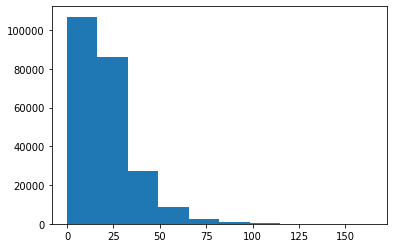

In [550]:
print(stats.describe(positive_scores['SCORE']))
plt.hist(positive_scores['SCORE'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
 <a list of 84 Text xticklabel objects>)

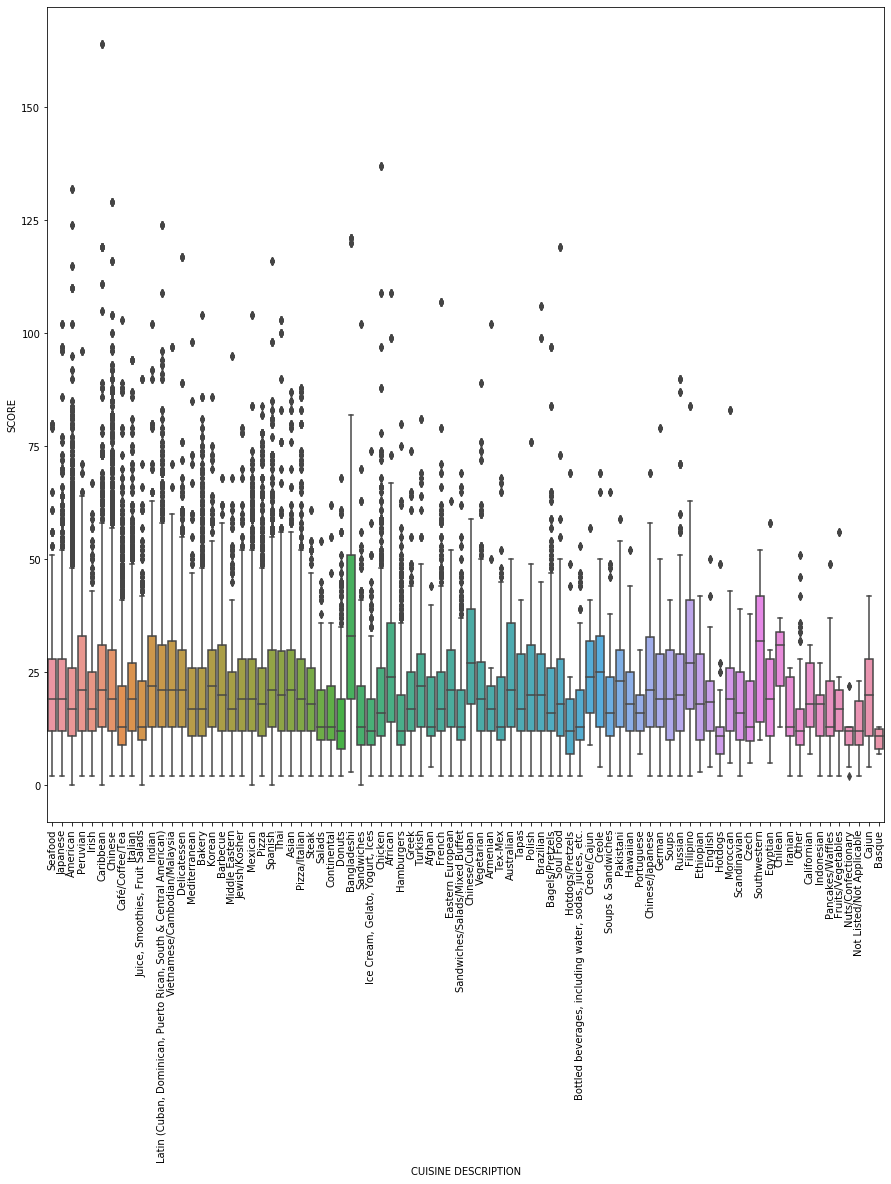

In [845]:
plt.figure(figsize=(15,15))
sns.boxplot(y=positive_scores['SCORE'], x=positive_scores['CUISINE DESCRIPTION'])
plt.xticks(rotation=90)

In [649]:
positive_scores['CUISINE DESCRIPTION'].value_counts()

American                                                            51788
Chinese                                                             23265
Café/Coffee/Tea                                                     11723
Latin (Cuban, Dominican, Puerto Rican, South & Central American)    10195
Italian                                                             10000
                                                                    ...  
Czech                                                                  36
Not Listed/Not Applicable                                              32
Nuts/Confectionary                                                     18
Chilean                                                                15
Basque                                                                  6
Name: CUISINE DESCRIPTION, Length: 84, dtype: int64

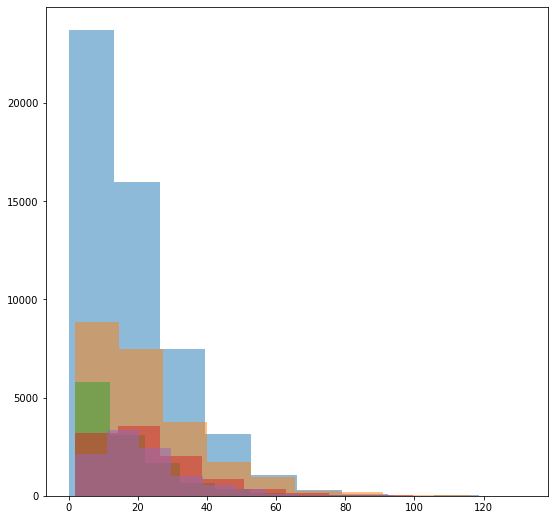

In [9]:
american = positive_scores[positive_scores['CUISINE DESCRIPTION'] == 'American']
chinese = positive_scores[positive_scores['CUISINE DESCRIPTION'] == 'Chinese']
cafe = positive_scores[positive_scores['CUISINE DESCRIPTION'] == 'Café/Coffee/Tea']
latin = positive_scores[positive_scores['CUISINE DESCRIPTION'] == 
                        'Latin (Cuban, Dominican, Puerto Rican, South & Central American)']
italian = positive_scores[positive_scores['CUISINE DESCRIPTION'] == 'Italian']

# Create a merged dataframe with these cuisines
merged = pd.concat([american, chinese, cafe, latin, italian])

plt.figure(figsize=(9,9))
plt.hist(american['SCORE'], alpha = .5)
plt.hist(chinese['SCORE'], alpha = .5)
plt.hist(cafe['SCORE'], alpha = .5)
plt.hist(latin['SCORE'], alpha = .5)
plt.hist(italian['SCORE'], alpha = .5)
plt.show()

In [554]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106971 entries, 6 to 400274
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CAMIS                106971 non-null  int64  
 1   CUISINE DESCRIPTION  106971 non-null  object 
 2   SCORE                106971 non-null  float64
 3   CRITICAL FLAG        106971 non-null  object 
 4   INSPECTION TYPE      106971 non-null  object 
 5   INSPECTION DATE      106971 non-null  object 
 6   DBA                  106971 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 6.5+ MB


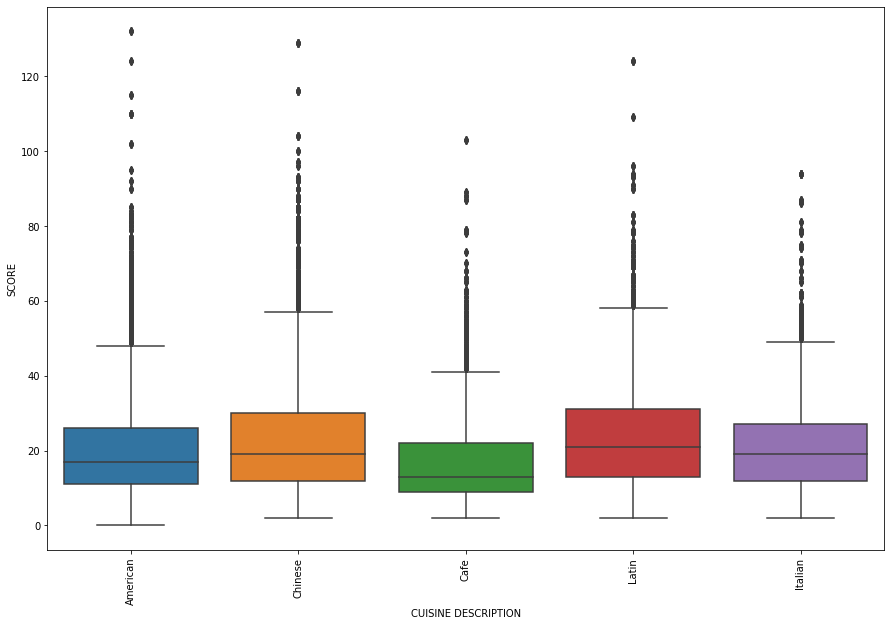

In [842]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(y='SCORE', x = 'CUISINE DESCRIPTION', data=merged)
plt.xticks([0, 1, 2, 3, 4], ['American', 'Chinese', 'Cafe', 'Latin', 'Italian'], rotation=90);

# Mood's Median Test
Given that this distribution is not normal and measures the effect of a categorical value on a continuous response, Mood's Median Test is the best option. Although Kruskal is more robust Mood's is more appropriate for a population with outliers. 

In [657]:
contingency.head()

SCORE,0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,102.0,103.0,104.0,109.0,110.0,115.0,116.0,124.0,129.0,132.0
CUISINE DESCRIPTION,,,,,,,,,,,,,,,,,,,,,
American,4,655,265,586,838,448,2086,1042,2541,2902,...,10,0,0,0,18,8,0,6,0,8
Café/Coffee/Tea,0,294,193,267,403,141,766,344,668,715,...,0,7,0,0,0,0,0,0,0,0
Chinese,0,148,89,205,216,140,613,409,985,1034,...,0,0,13,0,0,0,13,0,13,0
Italian,0,58,31,61,98,63,319,161,409,492,...,0,0,0,0,0,0,0,0,0,0
"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",0,35,19,57,59,39,180,140,362,317,...,0,0,0,7,0,0,0,11,0,0


In [690]:
cuisines = [american['SCORE'], chinese['SCORE'], cafe['SCORE'], latin['SCORE'], italian['SCORE']]

In [521]:
stats.median_test(american['SCORE'], chinese['SCORE'], cafe['SCORE'], latin['SCORE'], italian['SCORE'])

(1876.0748218009746,
 0.0,
 18.0,
 array([[23110, 12233,  4039,  6068,  5143],
        [28628, 10983,  7677,  4109,  4857]]))

In [590]:
for cuisine in merged['CUISINE DESCRIPTION'].unique():
    print(cuisine, ': median: {}'
          .format(merged[merged['CUISINE DESCRIPTION'] == cuisine]['SCORE'].median()))
    print(stats.median_test(merged[merged['CUISINE DESCRIPTION'] == cuisine]['SCORE']
                        , positive_scores['SCORE'])
                        , '\n')


American : median: 17.0
(245.03672872518177, 3.137041456623219e-55, 18.0, array([[ 23160, 112785],
       [ 28628, 119658]])) 

Chinese : median: 19.0
(154.1529227112643, 2.144417406747229e-35, 18.0, array([[ 12282, 112785],
       [ 10983, 119658]])) 

Café/Coffee/Tea : median: 13.0
(877.0468666839334, 9.585783159143328e-193, 18.0, array([[  4046, 112785],
       [  7677, 119658]])) 

Latin (Cuban, Dominican, Puerto Rican, South & Central American) : median: 21.0
(487.5607564580371, 4.836892124781725e-108, 18.0, array([[  6086, 112785],
       [  4109, 119658]])) 

Italian : median: 19.0
(32.347816791010025, 1.289019531136057e-08, 18.0, array([[  5143, 112785],
       [  4857, 119658]])) 



## Results

These results indicate that at least one or more group differes from the entire population significantly. In order to determine which groups might differ from the entire population we will run pairwise tests for each population against the entire population, including each cuisine being compared.


We will confirm the significance of these findings with a bootstrap resample to determine the confidence interval of our population medians.

In [11]:
def bootstrap_simulation(sample_data, num_realizations):
    n = sample_data.shape[0]
    boot = []
    for i in range(num_realizations):
        real = np.random.choice(sample_data.values.flatten(), size=n)
        boot.append(real)
        
    columns = ['Real ' + str(i + 1) for i in range(num_realizations)]
    
    return pd.DataFrame(boot, index=columns).T

def calc_sum_stats(boot_df):
    sum_stats = boot_df.describe().T[['mean', 'std', 'min', 'max']]
    sum_stats['median'] = boot_df.median()
    sum_stats['skew'] = boot_df.skew()
    sum_stats['kurtosis'] = boot_df.kurtosis()
    sum_stats['IQR'] = boot_df.quantile(0.75) - boot_df.quantile(0.25)
    return sum_stats.T
   
def calc_bounds(conf_level):
    
    assert (conf_level < 1), "Confidence level must be smaller than 1"
    
    margin = (1 - conf_level) / 2
    upper = conf_level + margin
    lower = margin
    return margin, upper, lower

def calc_confidence_interval(df_sum_stats, conf_level): 
    
    margin, upper, lower = calc_bounds(conf_level)
    
    conf_int_df = df_sum_stats.T.describe(percentiles=[lower, 0.5, upper]).iloc[4:7, :].T
    conf_int_df.columns = ['P' + str(round(lower * 100, 1)), 'P50', 'P' + str(round(upper * 100, 1))]
    return conf_int_df 

def print_confidence_interval(conf_df, conf_level):
    print('By {}% chance, the following statistics will fall within the range of:\n'.format(round(conf_level * 100, 1)))
    
    margin, upper, lower = calc_bounds(conf_level)
    
    upper_str = 'P' + str(round(upper * 100, 1))
    lower_str = 'P' + str(round(lower * 100, 1))
    
    for stat in conf_df.T.columns:
        lower_bound = round(conf_df[lower_str].T[stat], 1)
        upper_bound = round(conf_df[upper_str].T[stat], 1)

        mean = round(conf_df['P50'].T[stat], 1)
        print("{0:<10}: {1:>10}  ~ {2:>10} , AVG = {3:>5}".format(stat, lower_bound, upper_bound, mean))

In [18]:
american_bootstrap_sum = calc_sum_stats(bootstrap_simulation(american['SCORE'], 100))
chinese_bootstrap_sum = calc_sum_stats(bootstrap_simulation(chinese['SCORE'], 100))
cafe_bootstrap_sum = calc_sum_stats(bootstrap_simulation(cafe['SCORE'], 100))
latin_bootstrap_sum = calc_sum_stats(bootstrap_simulation(latin['SCORE'], 100))
italian_bootstrap_sum = calc_sum_stats(bootstrap_simulation(italian['SCORE'], 100))
merged_bootstrap_sum = calc_sum_stats(bootstrap_simulation(merged['SCORE'], 100))

sums = [american_bootstrap_sum, chinese_bootstrap_sum, cafe_bootstrap_sum, latin_bootstrap_sum
        , italian_bootstrap_sum, merged_bootstrap_sum]

In [17]:
print('Entire Population')
print_confidence_interval(calc_confidence_interval(merged_bootstrap_sum, .95), .95)
print('\n')

print('American')
print_confidence_interval(calc_confidence_interval(american_bootstrap_sum, .95), .95)
print('\n')

print('Chinese')
print_confidence_interval(calc_confidence_interval(chinese_bootstrap_sum, .95), .95)
print('\n')

print('Cafe')
print_confidence_interval(calc_confidence_interval(cafe_bootstrap_sum, .95), .95)
print('\n')

print('Latin')
print_confidence_interval(calc_confidence_interval(latin_bootstrap_sum, .95), .95)
print('\n')

print('Italian')
print_confidence_interval(calc_confidence_interval(italian_bootstrap_sum, .95), .95)

Entire Population
By 95.0% chance, the following statistics will fall within the range of:

mean      :       20.9  ~       21.1 , AVG =  21.0
std       :       14.1  ~       14.2 , AVG =  14.2
min       :        0.0  ~        1.0 , AVG =   0.0
max       :      132.0  ~      132.0 , AVG = 132.0
median    :       17.0  ~       18.0 , AVG =  18.0
skew      :        1.7  ~        1.8 , AVG =   1.7
kurtosis  :        4.4  ~        4.9 , AVG =   4.7
IQR       :       16.0  ~       16.0 , AVG =  16.0


American
By 95.0% chance, the following statistics will fall within the range of:

mean      :       19.9  ~       20.2 , AVG =  20.0
std       :       13.1  ~       13.4 , AVG =  13.2
min       :        0.0  ~        0.0 , AVG =   0.0
max       :      132.0  ~      132.0 , AVG = 132.0
median    :       16.0  ~       17.0 , AVG =  17.0
skew      :        1.7  ~        1.8 , AVG =   1.7
kurtosis  :        4.3  ~        5.3 , AVG =   4.8
IQR       :       15.0  ~       15.0 , AVG =  15.0


Chine

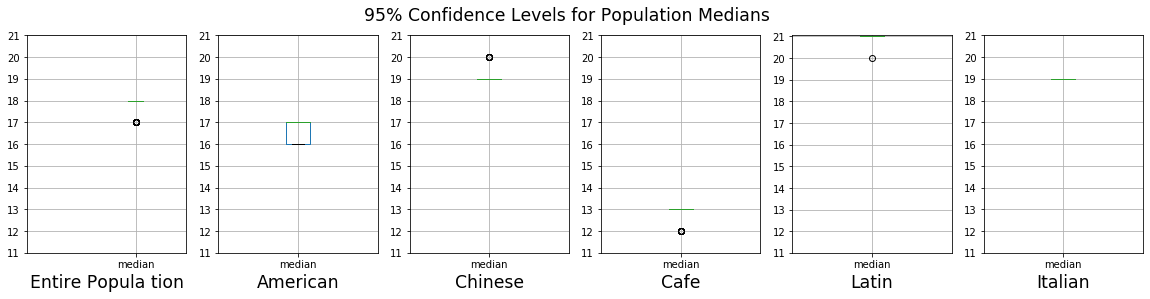

In [37]:
f = plt.figure(figsize = (20,4))
plt.suptitle('95% Confidence Levels for Population Medians', size='xx-large')

gs = gridspec.GridSpec(1, 6)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[0,4])
ax6 = plt.subplot(gs[0,5])

merged_bootstrap_sum.T[['median']].boxplot(ax=ax1)
american_bootstrap_sum.T[['median']].boxplot(ax=ax2)
chinese_bootstrap_sum.T[['median']].boxplot(ax=ax3)
cafe_bootstrap_sum.T[['median']].boxplot(ax=ax4)
latin_bootstrap_sum.T[['median']].boxplot(ax=ax5)
italian_bootstrap_sum.T[['median']].boxplot(ax=ax6)


ax1.set_xlabel('Entire Popula tion', size='xx-large')
ax1.set_yticks(np.arange(11, 22, step=1))

ax2.set_yticks(np.arange(11, 22, step=1))
ax2.set_xlabel('American', size='xx-large')

ax3.set_yticks(np.arange(11, 22, step=1))
ax3.set_xlabel('Chinese', size='xx-large')

ax4.set_yticks(np.arange(11, 22, step=1))
ax4.set_xlabel('Cafe', size='xx-large')

ax5.set_yticks(np.arange(11, 22, step=1))
ax5.set_xlabel('Latin', size='xx-large')

ax6.set_yticks(np.arange(11, 22, step=1))
ax6.set_xlabel('Italian', size='xx-large')
plt.show()

In [39]:
data = [merged_bootstrap_sum.T[['median']], american_bootstrap_sum.T[['median']], chinese_bootstrap_sum.T[['median']]]

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

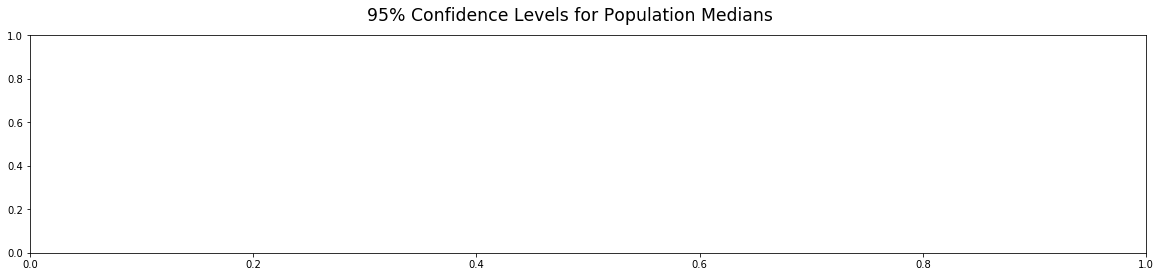

In [43]:
fig10, ax10 = plt.subplots(figsize = (20,4))
plt.suptitle('95% Confidence Levels for Population Medians', size='xx-large')


ax10.boxplot(merged_bootstrap_sum.T[['median']], american_bootstrap_sum.T[['median']])
plt.show()

#### Not only did our Mood's test show that the populations are significantly different but American cuisine is the only population where the confidence interval of the median overlapped with the confidence interval of the entire population. This further suggestst that there is indeed a significant difference between the other populations and the entire population.

## Discussions and  Reccomendations

Given the significance of these results we can reject our null hypothesis. Chinese, Latin and Italian cuisines all score significantly different from the population as a whole. American cuisine can not be determined to be different at this time.

This data set contains a lot of information but requires even more context for interpret. By better understanding the inspection and scoring process we can get more accurate interprative results from this data. While there are many outliers in this data set, our analysis shows that most operators recieve a grade of B or better. In some cases we know restaurants operate under close supervision if they repeatedly do poorly on the test. More meta data will help us uderstand under what circumstances restaurants who recieve very high scores are allowed to remain open.



Furthermore going forward it may be most explore these abnormally high scores and test for significant relationships with some other variables.